## Spark Initialization

In [1]:
import findspark
findspark.init()
import pyspark
import pandas as pd
import seaborn as sns # To get graphs
import matplotlib.pyplot as plt # To get graphs

### Spark Session Creation

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[1]") \
                    .appName('ModelVal') \
                    .getOrCreate()

In [3]:
spark

### Spark Model

In [4]:
#df = spark.read.option("header" , True).csv("D:\\Vizuamatix exam\\final_dispatch.csv")
df = spark.read.option("header" , True).csv("/Users/Asus/Documents/InternCsv/combine_final.csv")

In [6]:
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window
df_dev = df.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("Date","Time","Plant")))

In [8]:
df_dev.show()

+-------------+--------+----+---------------+-------------------+----------+--------------------+
|        Plant|    Date|Time|Actual_Dispatch|Forecasted_Dispatch|Difference|                rank|
+-------------+--------+----+---------------+-------------------+----------+--------------------+
|     ACE EMBP|7/1/2020|0:00|              0|                 51|       -51|                 0.0|
|   ACE Matara|7/1/2020|0:00|              0|                  0|         0|2.154475923731552...|
|ALTAQQA-Mahi.|7/1/2020|0:00|              0|                  0|         0|4.308951847463105E-5|
| ALTAQQA-Pol.|7/1/2020|0:00|              0|                  0|         0|6.463427771194657E-5|
|   Asia Power|7/1/2020|0:00|              0|                 33|       -33| 8.61790369492621E-5|
|        Barge|7/1/2020|0:00|             90|                 45|        45|1.077237961865776...|
|         Bowa|7/1/2020|0:00|              0|                  0|         0|1.292685554238931...|
|CEB Sup Power|7/1/2

In [9]:
train_df = df_dev.where("rank <= .8").drop("rank")
train_df.show()

+-------------+--------+----+---------------+-------------------+----------+
|        Plant|    Date|Time|Actual_Dispatch|Forecasted_Dispatch|Difference|
+-------------+--------+----+---------------+-------------------+----------+
|     ACE EMBP|7/1/2020|0:00|              0|                 51|       -51|
|   ACE Matara|7/1/2020|0:00|              0|                  0|         0|
|ALTAQQA-Mahi.|7/1/2020|0:00|              0|                  0|         0|
| ALTAQQA-Pol.|7/1/2020|0:00|              0|                  0|         0|
|   Asia Power|7/1/2020|0:00|              0|                 33|       -33|
|        Barge|7/1/2020|0:00|             90|                 45|        45|
|         Bowa|7/1/2020|0:00|              0|                  0|         0|
|CEB Sup Power|7/1/2020|0:00|              0|                  0|         0|
|       Canyon|7/1/2020|0:00|             20|                  0|        20|
|         KCCP|7/1/2020|0:00|              0|                  0|         0|

In [10]:
train_df = train_df.withColumn("Difference",train_df.Difference.cast('double'))

In [12]:
train_df = train_df.withColumn("Actual_Dispatch",train_df.Actual_Dispatch.cast('double'))
train_df = train_df.withColumn("Forecasted_Dispatch",train_df.Forecasted_Dispatch.cast('double'))

In [14]:
train_df.dtypes

[('Plant', 'string'),
 ('Date', 'string'),
 ('Time', 'string'),
 ('Actual_Dispatch', 'double'),
 ('Forecasted_Dispatch', 'double'),
 ('Difference', 'double')]

In [15]:
from pyspark.sql.functions import col
sumtot = train_df.groupBy("Plant").sum("Actual_Dispatch","Forecasted_Dispatch","Difference").sort(col("Plant").asc())

In [16]:
sumtot.show(10)

+-------------+--------------------+------------------------+---------------+
|        Plant|sum(Actual_Dispatch)|sum(Forecasted_Dispatch)|sum(Difference)|
+-------------+--------------------+------------------------+---------------+
|     ACE EMBP|            134409.0|                 61367.0|        73042.0|
|   ACE Matara|             27330.0|                 14225.0|        13105.0|
|ALTAQQA-Mahi.|              1451.0|                   650.0|          801.0|
| ALTAQQA-Pol.|              1656.0|                   528.0|         1128.0|
|   Asia Power|             34513.0|                 23497.0|        11016.0|
|        Barge|            107826.0|                 56437.0|        51389.0|
|         Bowa|             18718.0|                  9166.0|         9552.0|
|CEB Sup Power|              7920.0|                  1316.0|         6604.0|
|       Canyon|             26068.0|                 13899.0|        12169.0|
|         KCCP|                 0.0|                     0.0|   

In [21]:
from pyspark.sql.functions import *
newColumns = ["Plant","Actual_Dispatch","Forecasted_Dispatch","DispatchDiff"]
sumtot=sumtot.toDF(*newColumns)

In [22]:
sumtot.show()

+-------------+---------------+-------------------+------------+
|        Plant|Actual_Dispatch|Forecasted_Dispatch|DispatchDiff|
+-------------+---------------+-------------------+------------+
|     ACE EMBP|       134409.0|            61367.0|     73042.0|
|   ACE Matara|        27330.0|            14225.0|     13105.0|
|ALTAQQA-Mahi.|         1451.0|              650.0|       801.0|
| ALTAQQA-Pol.|         1656.0|              528.0|      1128.0|
|   Asia Power|        34513.0|            23497.0|     11016.0|
|        Barge|       107826.0|            56437.0|     51389.0|
|         Bowa|        18718.0|             9166.0|      9552.0|
|CEB Sup Power|         7920.0|             1316.0|      6604.0|
|       Canyon|        26068.0|            13899.0|     12169.0|
|         KCCP|            0.0|                0.0|         0.0|
|      KPS(GT)|            0.0|                0.0|         0.0|
|     KPS(GT7)|          350.0|                0.0|       350.0|
|         Koth|        74

In [23]:
df1 = sumtot.toPandas()
df1.head()

,Plant,Actual_Dispatch,Forecasted_Dispatch,DispatchDiff
0,ACE EMBP,134409.0,61367.0,73042.0
1,ACE Matara,27330.0,14225.0,13105.0
2,ALTAQQA-Mahi.,1451.0,650.0,801.0
3,ALTAQQA-Pol.,1656.0,528.0,1128.0
4,Asia Power,34513.0,23497.0,11016.0


### Heatmap for Find Correlations

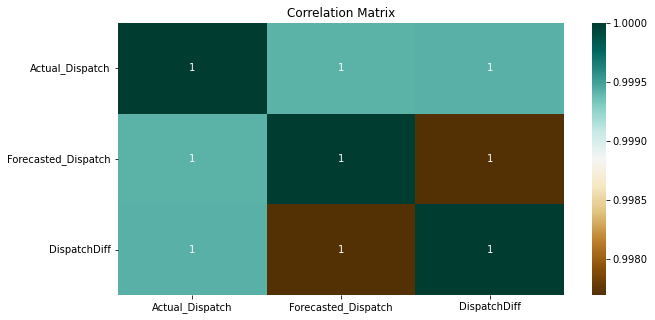

In [24]:
# Correlation Heatmap
plt.figure(figsize = (10, 5))
c = df1.corr()
sns.heatmap(c, cmap = "BrBG", annot = True)
plt.title("Correlation Matrix")
plt.show()

In [25]:
df1.dtypes

Plant                   object
Actual_Dispatch        float64
Forecasted_Dispatch    float64
DispatchDiff           float64
dtype: object

In [49]:
# Dependent variables
import numpy as np
X=df1.iloc[:,2:].values
y=df1['Actual_Dispatch'].values

In [50]:
#print((x))
print((y))

[1.34409e+05 2.73300e+04 1.45100e+03 1.65600e+03 3.45130e+04 1.07826e+05
 1.87180e+04 7.92000e+03 2.60680e+04 0.00000e+00 0.00000e+00 3.50000e+02
 7.47090e+04 7.57350e+04 5.62074e+05 5.56148e+05 5.49420e+05 9.38650e+04
 4.64210e+04 7.86980e+04 4.44440e+04 2.31230e+04 1.74150e+04 8.08780e+04
 1.22662e+05 9.78670e+04 5.15360e+04 5.30280e+04 2.74960e+04 4.43500e+03
 1.02960e+04 0.00000e+00 1.09570e+04 3.86180e+04 4.57308e+05 1.41130e+04]


In [51]:
# Normalize Data
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.15614829,  0.32854029],
       [-0.43741911, -0.4249838 ],
       [-0.60834264, -0.57966889],
       [-0.60987875, -0.57555787],
       [-0.32067487, -0.45124657]])

## Train Test Split

In [52]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Logistic Regression

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C = 0.01, solver = "liblinear")
LR.fit(X, y)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [54]:
# Now we can predict using our test set
yhat = LR.predict(x_test)
yhat

array([     0.,      0., 562074.,      0.,      0., 562074.,      0.,
            0.])

In [56]:
yhat_prob = LR.predict_proba(x_test)
#yhat_prob

### Evaluation

### Confussion Matrix

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[0 0]
 [0 2]]


Confusion matrix, without normalization
[[0 0]
 [0 2]]


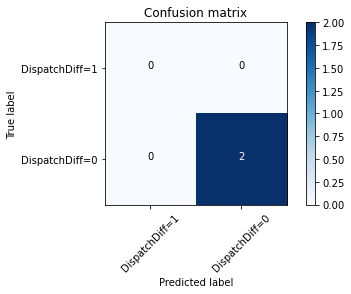

In [59]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
#Prediction 
plot_confusion_matrix(cnf_matrix, classes=['DispatchDiff=1','DispatchDiff=0'],normalize= False,  title='Confusion matrix')

## Model Validation

In [64]:

print(classification_report(y_test, yhat))
#1st Column dictates the Dispacth Unit in in Each Plants

              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         2
      1451.0       0.00      0.00      0.00         1
     10296.0       0.00      0.00      0.00         1
     17415.0       0.00      0.00      0.00         1
     44444.0       0.00      0.00      0.00         1
    549420.0       0.00      0.00      0.00         1
    556148.0       0.00      0.00      0.00         1
    562074.0       0.00      0.00      0.00         0

    accuracy                           0.25         8
   macro avg       0.04      0.12      0.06         8
weighted avg       0.08      0.25      0.12         8



C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classif

### f1 score for Plants Dispatches Between 0 - 1460

In [65]:
2*(0.33*1/(0.33+1.00))  #Prediction Rate

0.49624060150375937

In [74]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

classifier = make_pipeline(StandardScaler(), LinearSVC(random_state=random_state))
classifier.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(random_state=RandomState(MT19937) at 0x14C08353340))])